# Exercício de análise e seleção de modelos de regressão linear

Como pessoa Cientista de Dados, você está encarregada pela análise do problema de precificação de quartos de hotéis, fazendo uso do conjunto de dados fornecidos. Para isso, você dispõe desse dataset.

Nesta atividade, sua tarefa envolve conduzir as seguintes etapas:

- análise inicial com o PairPlot da Seaborn;
- construir modelos de regressão linear; e
- realizar a comparação desses modelos.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy.stats import probplot

## Importando os Dados

In [3]:
df = pd.read_csv("hoteis.csv")
df.head()

,Estrelas,ProximidadeTurismo,Capacidade,Preco
0,5,9.301565,3,506.275452
1,1,1.785891,1,246.363458
2,4,15.504293,3,325.873550
3,4,4.173188,3,521.343284
4,4,9.443685,1,252.587087


## Conhecendo os Dados

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estrelas            1000 non-null   int64  
 1   ProximidadeTurismo  1000 non-null   float64
 2   Capacidade          1000 non-null   int64  
 3   Preco               1000 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 31.4 KB


In [5]:
df.describe()

,Estrelas,ProximidadeTurismo,Capacidade,Preco
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.008000,7.650878,2.519000,396.611361
std,1.407095,5.870137,1.108543,171.742433
min,1.000000,0.013850,1.000000,-220.208705
25%,2.000000,3.034775,2.000000,283.590980
50%,3.000000,6.430035,3.000000,401.743527
75%,4.000000,10.863295,4.000000,516.097856
max,5.000000,31.709748,4.000000,836.261308


Pode-se observar os seguintes fatores sobre o dataset de hotéis:
- 1000 listagens.
- Média de capacidade de 2 a 3 pessoas.
- Média de 7.65Km de proximidade de pontos turísticos.
- Capacidades variando de 1 a 4 pessoas.
- Distâncias de pontos turísticos variando de 100m a 32Km.
- Estrelas variando de 1 a 5, com uma média de 3.
- Preço de hospedagens com média de R$396,61.
- Variação de preço de -220 a 836. Indicando sujeira no dataset.


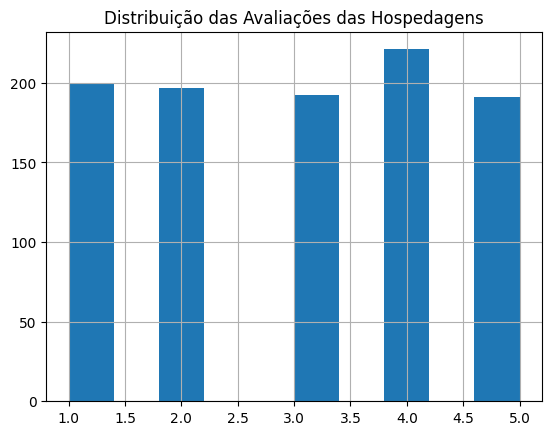

In [6]:
df.Estrelas.hist()
plt.title('Distribuição das Avaliações das Hospedagens')
plt.show()

Observa-se uma distribuição bem equilibrada das avaliações dos hotéis.

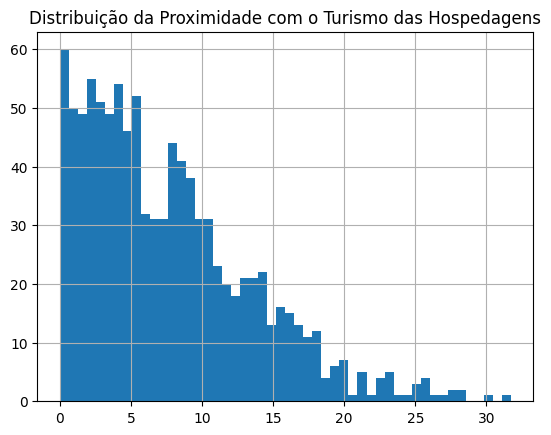

In [7]:
df.ProximidadeTurismo.hist(bins=50)
plt.title('Distribuição da Proximidade com o Turismo das Hospedagens')
plt.show()

Vemos a Proximidade com Turísmo mais concentrada em distâncias menores dos pontos de interesse do que distantes dos mesmos.

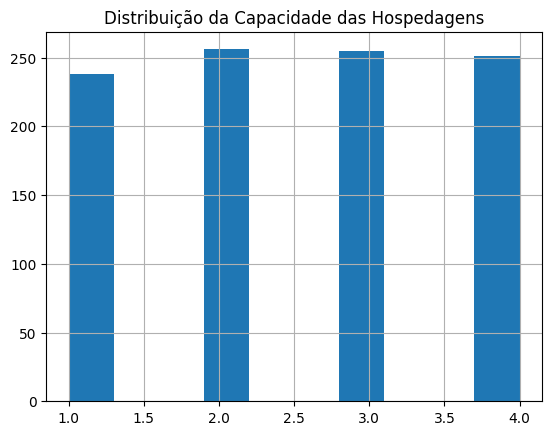

In [8]:
df.Capacidade.hist()
plt.title('Distribuição da Capacidade das Hospedagens')
plt.show()

Novamente vemos um gráfico de distribuição bem equilibrado. Porém podemos notar que hospedagens com capacidade para 1 pessoa são as menos frequentes.

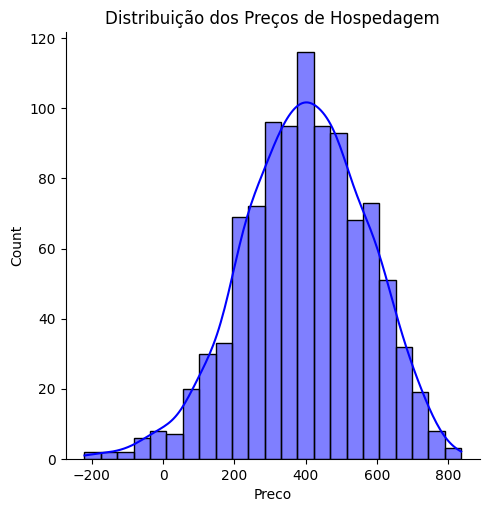

In [9]:
sns.displot(df.Preco, kde=True, color="blue")
plt.title('Distribuição dos Preços de Hospedagem')
plt.show()

Pode-se observar que o preço médio das hospedagens gira em torno de R$400, com uma distribuição seguindo um padrão normal.

Porém podemos também ver que há valores negativos no dataset. Considerando que hospedagens não costumam pagar para os hóspedes frequentarem seus estabelicimentos, vamos transformar os valores negativos em positivos.

## Limpando os dados

In [10]:
df.Preco = df.Preco.apply(lambda x: np.abs(x) if x < 0 else x)

In [11]:
print("Preço Min: ", df.Preco.min())
print("Preço Max: ", df.Preco.max())

Preço Min:  1.6057343397926471
Preço Max:  836.2613078967568


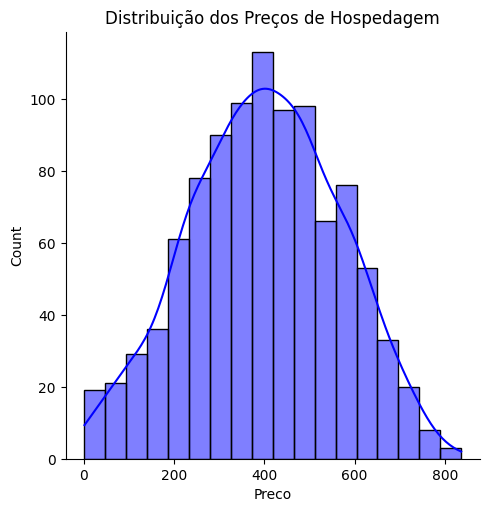

In [12]:
sns.displot(df.Preco, kde=True, color="blue")
plt.title('Distribuição dos Preços de Hospedagem')
plt.show()

Considerando-se que estamos falando de hospedagens e estamos em 2025. E que mesmo, por exemplo, 15 anos atrás pagar menos que R$20 numa diária já era quase impossível. Vamos ver quantos valores temos abaixo de R$20 e analisar se devemos deixá-los no dataset ou não.

In [13]:
df.Preco[df.Preco < 20]

46      1.605734
126     7.268904
137     9.364953
180    12.168455
229    13.951666
561     5.397100
753    11.603584
804    10.714595
833    15.609632
Name: Preco, dtype: float64

Como são poucos os valores abaixo de R$20, decido por removê-los do dataset.

In [14]:
df.drop(df.Preco[df.Preco < 20].index, axis=0, inplace=True)

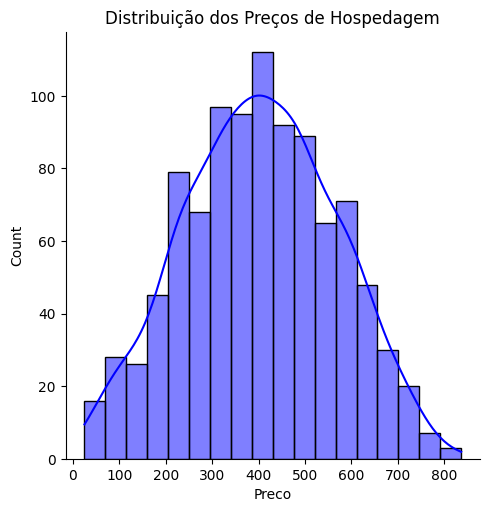

In [15]:
sns.displot(df.Preco, kde=True, color="blue")
plt.title('Distribuição dos Preços de Hospedagem')
plt.show()

Podemos ver pelo gráfico acima que agora não temos valores muito próximos de zero na coluna de Preços.

## Correlacionando Características das Hospedagens

Com o intuito de criar um modelo de predição de preço de hospedagens com o dataset aqui em contexto, precisamos analisar a correlação entre as propriedades(colunas) que formam o dataset buscando as que possuem maior relação entre si. Estas propriedades são as que devemos utilizar para treinar nosso modelo.

In [16]:
corr = df.corr()
corr

,Estrelas,ProximidadeTurismo,Capacidade,Preco
Estrelas,1.000000,0.005865,-0.027189,0.409628
ProximidadeTurismo,0.005865,1.000000,-0.009940,-0.665429
Capacidade,-0.027189,-0.009940,1.000000,0.528804
Preco,0.409628,-0.665429,0.528804,1.000000


Note que com uma tabela de correlação, podemos focar apenas nos valores do triângulo inferior.

Vamos criar um heatmap para facilitar a interpretação da tabela.

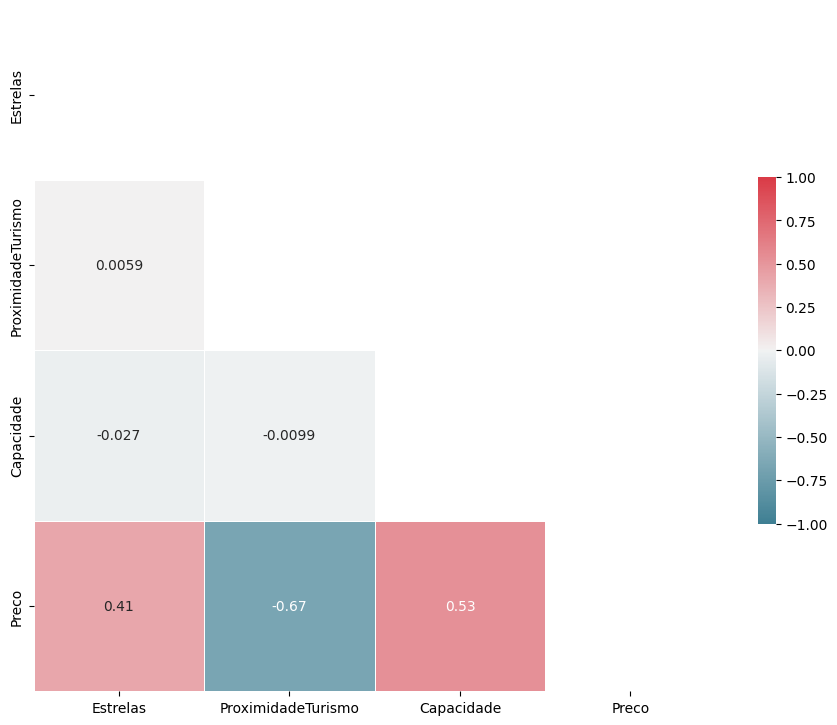

In [17]:
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

Podemos observar que:
- Proximidade com o Turismo, Capacidade e Estrelas não possuem correlação significativa entre si.
- Preço e Estrelas(.41) e Preço e Capacidade(.53) apresentam correlações moderadas.
- Preço e Proximidade com o Turismo apresentam a maior correlação, -0.67, sendo uma correlação negativa, quanto mais próxima do turismo, mais cara tende a ser a hospedagem.

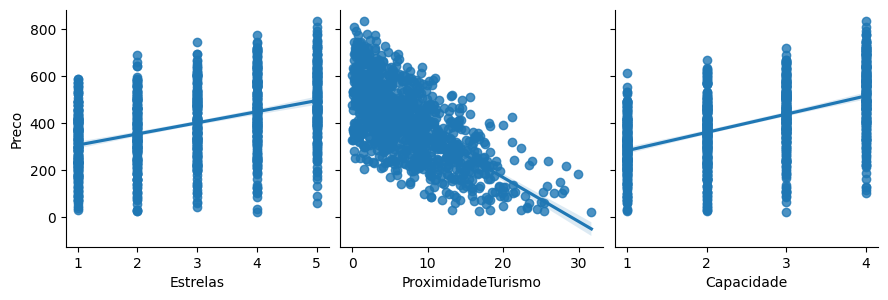

In [19]:
sns.pairplot(df, y_vars="Preco", x_vars=["Estrelas", "ProximidadeTurismo", "Capacidade"], kind="reg", height=3)

Nota-se que o conjunto de dados que melhor apresenta, pelo menos visualmente, um comportamento linear é o de Proximidade com o Turismo. 

Porém, como podemos ver os preços aumentando seu limite superior para maiores Estrelas e Capacidades, e também considerando o mapa de calor gerado acima, vamos verificar como os modelos incluindo tais variáveis se comporta.

## Gerando modelos lineares

Primeiro setamos os dados de treino e teste.

In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(df.drop(columns="Preco"), df['Preco'], test_size=0.3, random_state=230)

In [21]:
dftrain = pd.DataFrame(data=xtrain)
dftrain["Preco"] = ytrain

In [37]:
dftest = pd.DataFrame(data=xtest)
dftest["Preco"] = ytest

### Modelo considerando apenas Proximidade com Turismo

In [22]:
model_pt = ols("Preco ~ ProximidadeTurismo", data = dftrain).fit()

In [23]:
print(model_pt.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     555.6
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.34e-90
Time:                        19:03:51   Log-Likelihood:                -4310.6
No. Observations:                 693   AIC:                             8625.
Df Residuals:                     691   BIC:                             8634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            544.4526      7

Vemos um intercepto de 544.45, indicando o preço esperado da pousada caso a variável independente seja 0. E temos uma variável independente com coeficiente negativo -18.91, indicando que para cada quilometro adicionado à distância da pousada de um centro turístico, o valor da hospedagem tende a diminuir.

Porém, nota-se que o R² mostra uma explicabilidade de apenas 0.445 no valor da hospedagem.

Vamos checar os resíduos deste modelo:

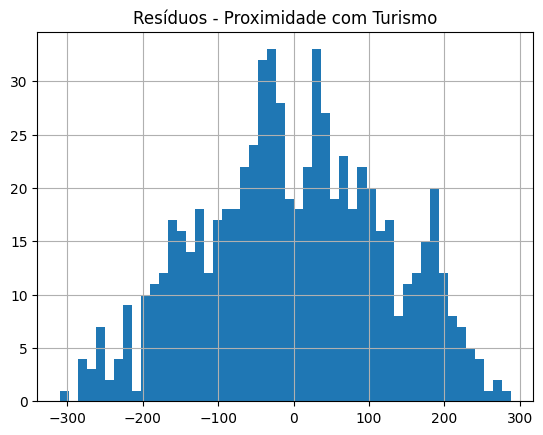

In [24]:
model_pt.resid.hist(bins=50)
plt.title("Resíduos - Proximidade com Turismo")
plt.show()

Vemos que os resíduos aqui se comportam relativamente como uma normal, se agrupando em torno de 0, representando que a linha da regressão divide relativamente bem os valores da distribuição ProximidadeTurismo x Preço.

Podemos usar o gráfico "probplot" do scipy.stats para ter uma visão dos resíduos organizados em quantis e distribuidos ao longo de uma reta. Neste gráfico procuramos ver a maioria dos pontos distribuidos quase exatamente sobre a reta, o que indicaria que os resíduos realmente se comportam como uma normal.

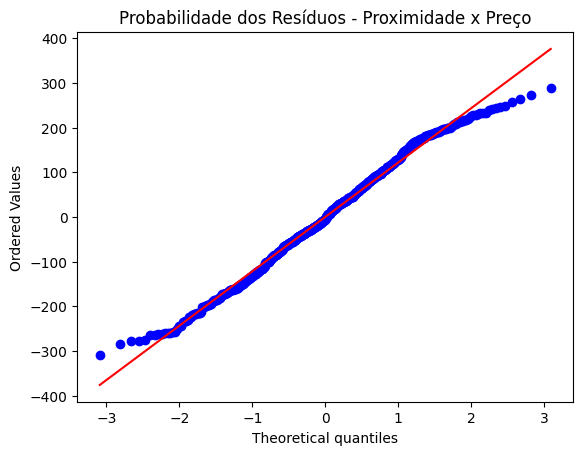

In [25]:
(_, (_,_,_)) = probplot(model_pt.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Proximidade x Preço")
plt.show()

Note como os valores seguem a reta entre os quantis (-2,2). Veja que tais valores batem com uma quebra de padrão brusca no histograma visto acima nos valores -200 e 200.

De qualquer forma, podemos ainda considerar estes resíduos como se comportando como uma normal. Só precisamos ter em mente que a explicabilidade do modelo foi de apenas 44%.

Vejamos agora a explicabilidade sobre os dados de teste.

In [26]:
y_predict = model_pt.predict(xtest)
print("R²: ", r2_score(ytest, y_predict))

R²:  0.4352423007738909


Vemos um valor bem próximo da explicabilidade vista sobre os dados de treino. Indicando que o modelo está se comportando como esperado, que não há, aparentemente, nenhum viés nos dados utilizados até agora.

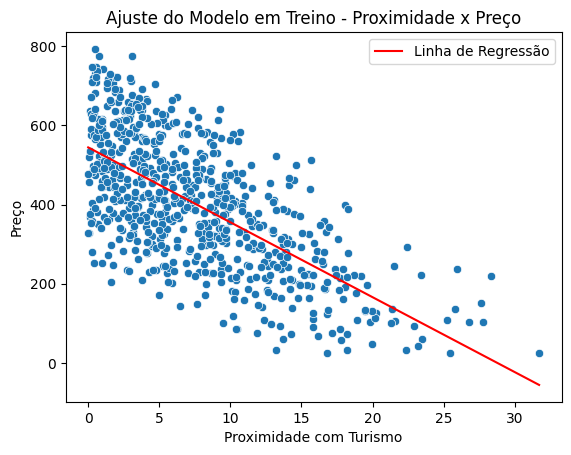

In [27]:
sns.scatterplot(data=dftrain, x = "ProximidadeTurismo", y = "Preco")

x_range = np.linspace(dftrain['ProximidadeTurismo'].min(), dftrain['ProximidadeTurismo'].max(), 100)
y_pred = model_pt.predict(pd.DataFrame({"ProximidadeTurismo": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Treino - Proximidade x Preço")
plt.xlabel("Proximidade com Turismo")
plt.ylabel("Preço")
plt.legend()
plt.show()

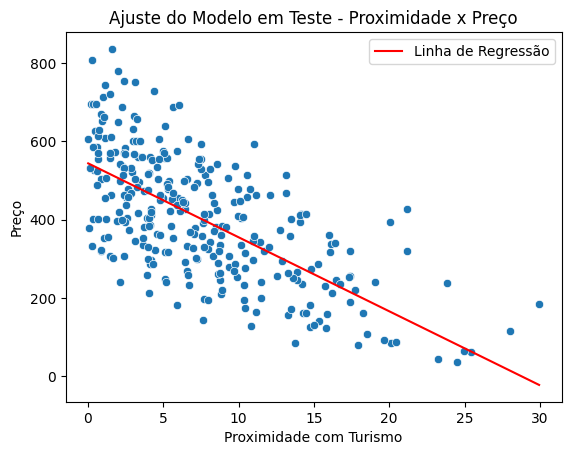

In [28]:
sns.scatterplot(data=dftest, x = "ProximidadeTurismo", y = "Preco")

x_range = np.linspace(dftest['ProximidadeTurismo'].min(), dftest['ProximidadeTurismo'].max(), 100)
y_pred = model_pt.predict(pd.DataFrame({"ProximidadeTurismo": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Teste - Proximidade x Preço")
plt.xlabel("Proximidade com Turismo")
plt.ylabel("Preço")
plt.legend()
plt.show()

### Modelo considerando apenas Capacidade

In [30]:
model_cp = ols("Preco ~ Capacidade", data = dftrain).fit()
print(model_cp.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     244.3
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           2.19e-47
Time:                        19:07:04   Log-Likelihood:                -4410.1
No. Observations:                 693   AIC:                             8824.
Df Residuals:                     691   BIC:                             8833.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    212.7966     13.219     16.098      0.0

Aqui notamos um intercepto de 212.79, indicando o valor esperado da hospedagem caso a variável Capacidade fosse 0. O coeficiente da variável independente ficou em 75.01, sendo o valor em que o Preço varia quando se altera em uma unidade o valor da Capacidade.

Por mais que a explicabilidade dos dados seja baixa, 0.26 apenas, o valor P se manteve baixo, indicando que a variável é sim significante para um modelo linear.

Checando os resíduos:

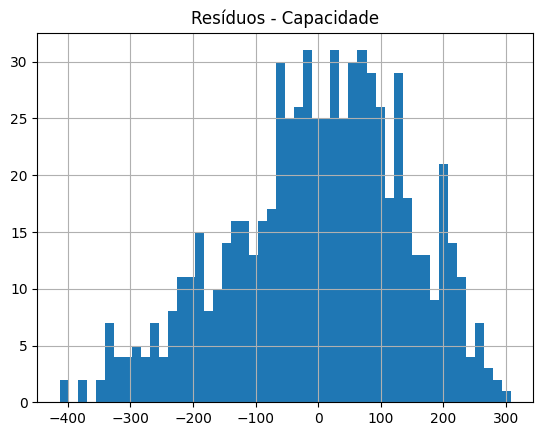

In [31]:
model_cp.resid.hist(bins=50)
plt.title("Resíduos - Capacidade")
plt.show()

Notamos uma certa assimetria à esquerda, porém ainda os dados parecem ser distribuidos em sua maioria em torno de zero. Vejamos o gráfico probplot:

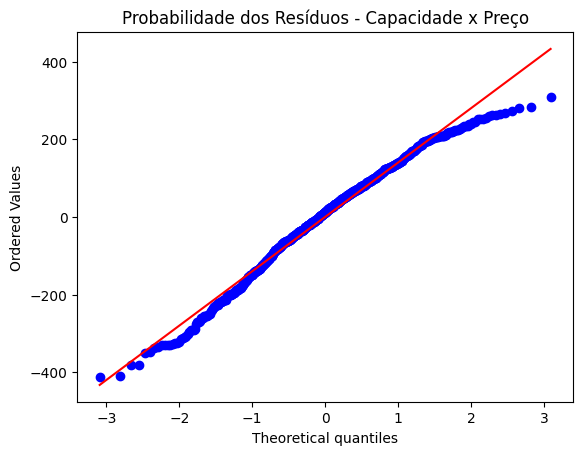

In [32]:
(_, (_,_,_)) = probplot(model_cp.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Capacidade x Preço")
plt.show()

Note os pontos distribuidos sobre a linha entre os quantis -1 e 1, e se afastando nas extremidades. Podemos dizer que os dados ainda se comportam como uma normal.

Verificando a explicabilidade com os dados de teste:

In [33]:
y_predict = model_cp.predict(xtest)
print("R²: ", r2_score(ytest, y_predict))

R²:  0.3235282467220262


Agora vemos a explicabilidade um pouco mais distante, e elevada, do que nos dados de treinamento. Isso poderia indicar um viés na variável Capacidade e/ou na separação dos dados de treino. Pode ainda ser devido à característica discreta da variável, que está no intervalo 1-4. Ou também o simples fato de que no dataset de teste há menos valores, e talvez estes estejam mais agrupados perto da linha do que no dataset de treino. 

De qualquer forma a diferença ainda é pouca, e não creio impedir o uso da variável num modelo maior.

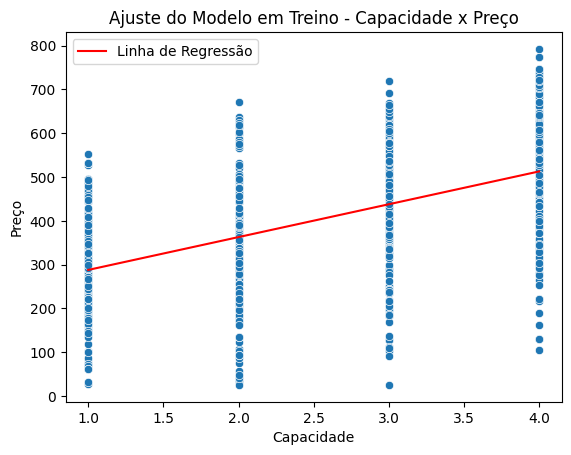

In [35]:
sns.scatterplot(data=dftrain, x = "Capacidade", y = "Preco")

x_range = np.linspace(dftrain['Capacidade'].min(), dftrain['Capacidade'].max(), 100)
y_pred = model_cp.predict(pd.DataFrame({"Capacidade": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Treino - Capacidade x Preço")
plt.xlabel("Capacidade")
plt.ylabel("Preço")
plt.legend()
plt.show()

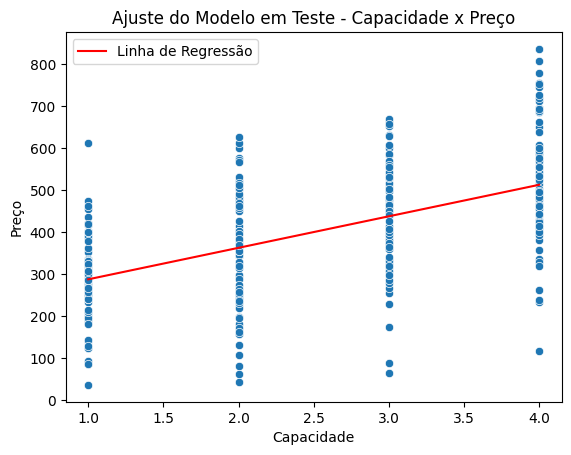

In [36]:
sns.scatterplot(data=dftest, x = "Capacidade", y = "Preco")

x_range = np.linspace(dftest['Capacidade'].min(), dftest['Capacidade'].max(), 100)
y_pred = model_cp.predict(pd.DataFrame({"Capacidade": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Teste - Capacidade x Preço")
plt.xlabel("Capacidade")
plt.ylabel("Preço")
plt.legend()
plt.show()

### Modelo considerando apenas Estrelas

In [38]:
model_es = ols("Preco ~ Estrelas", data = dftrain).fit()
print(model_es.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     166.3
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           3.01e-34
Time:                        19:30:27   Log-Likelihood:                -4440.3
No. Observations:                 693   AIC:                             8885.
Df Residuals:                     691   BIC:                             8894.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    249.4806     13.063     19.098      0.0

Vemos um intercepto de 249.48 e um coeficiente de 50.52 para a variável independente Estrelas. O valor P é baixo, indicando nenhum problema na significância da variável. Porém, a explicabilidade atingida é de apenas 0.19, menor ainda que o uso da variável Capacidade.

Checando os resíduos:

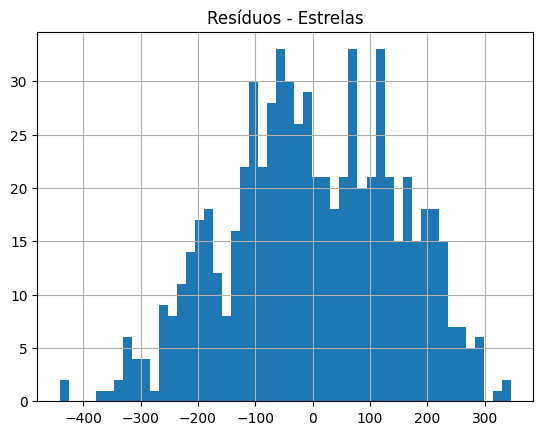

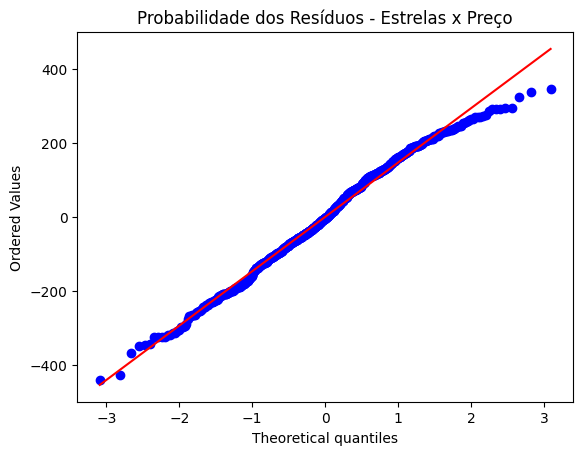

In [39]:
model_es.resid.hist(bins=50)
plt.title("Resíduos - Estrelas")
plt.show()

(_, (_,_,_)) = probplot(model_es.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Estrelas x Preço")
plt.show()

Novamente vemos uma leve assimetria a esquerda, porém os dados também parecem se comportar como uma normal.

Checando a explicabilidade com os dados de teste:

In [40]:
y_predict = model_es.predict(xtest)
print("R²: ", r2_score(ytest, y_predict))

R²:  0.10057242591142268


E novamente vemos um valor baixo e que também se afasta da explicabilidade atingida nos dados de Treino. Os mesmos fatores levantados para o cenário da variável Capacidade se aplicam aqui: viéses, separação dos dados de treino e teste, distribuição dos dados ao longo da linha e intervalo discreto da variável.

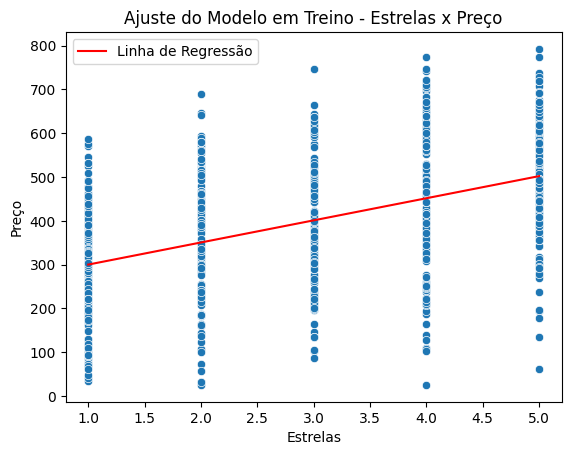

In [42]:
sns.scatterplot(data=dftrain, x = "Estrelas", y = "Preco")

x_range = np.linspace(dftrain['Estrelas'].min(), dftrain['Estrelas'].max(), 100)
y_pred = model_es.predict(pd.DataFrame({"Estrelas": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Treino - Estrelas x Preço")
plt.xlabel("Estrelas")
plt.ylabel("Preço")
plt.legend()
plt.show()

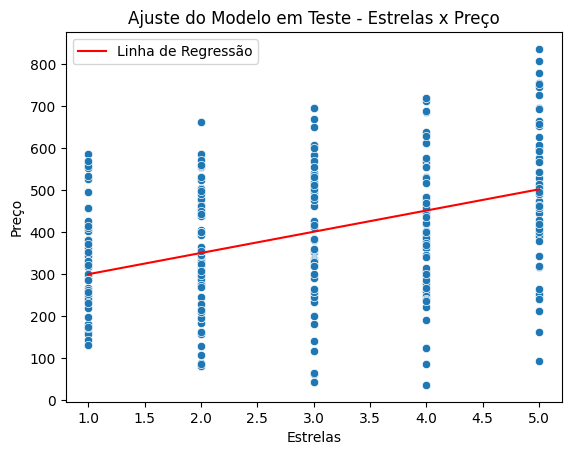

In [43]:
sns.scatterplot(data=dftest, x = "Estrelas", y = "Preco")

x_range = np.linspace(dftest['Estrelas'].min(), dftest['Estrelas'].max(), 100)
y_pred = model_es.predict(pd.DataFrame({"Estrelas": x_range}))
plt.plot(x_range, y_pred, color="red", label="Linha de Regressão")

plt.title("Ajuste do Modelo em Teste - Estrelas x Preço")
plt.xlabel("Estrelas")
plt.ylabel("Preço")
plt.legend()
plt.show()

## Gerando modelos compostos baseados em Proximidade, Capacidade e Estrelas

Até agora testamos modelos simples, com apenas uma variável, e atingimos os seguintes resultados:

||Proximidade|Capacidade|Estrelas|
|-|-|-|-|
|**R²**|0.446|0.261|0.194|
|**R² Adj.**|0.445|0.260|0.193|
|**R² Prev.**|0.435|0.323|0.100|

Vamos verificar agora onde conseguimos checar com modelos que agrupem até todas as três variáveis juntas.

In [44]:
xtrain = sm.add_constant(xtrain)
xtrain.head()

,const,Estrelas,ProximidadeTurismo,Capacidade
771,1.0,5,9.623417,2
198,1.0,4,0.745864,3
767,1.0,4,5.863200,4
821,1.0,1,11.884244,1
279,1.0,4,8.589199,4


In [45]:
model_pt_cp_es = sm.OLS(
    ytrain, 
    xtrain[["const", "Estrelas", "ProximidadeTurismo", "Capacidade"]]
    ).fit()

model_pt_cp = sm.OLS(
    ytrain, 
    xtrain[["const", "ProximidadeTurismo", "Capacidade"]]
    ).fit()

model_pt_es = sm.OLS(
    ytrain, 
    xtrain[["const", "ProximidadeTurismo", "Estrelas"]]
    ).fit()

model_es_cp = sm.OLS(
    ytrain, 
    xtrain[["const", "Capacidade", "Estrelas"]]
    ).fit()

### Modelo Estrelas x Capacidade

In [46]:
print(model_es_cp.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     306.6
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           5.24e-96
Time:                        19:56:37   Log-Likelihood:                -4294.7
No. Observations:                 693   AIC:                             8595.
Df Residuals:                     690   BIC:                             8609.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.9155     14.962      3.269      0.0

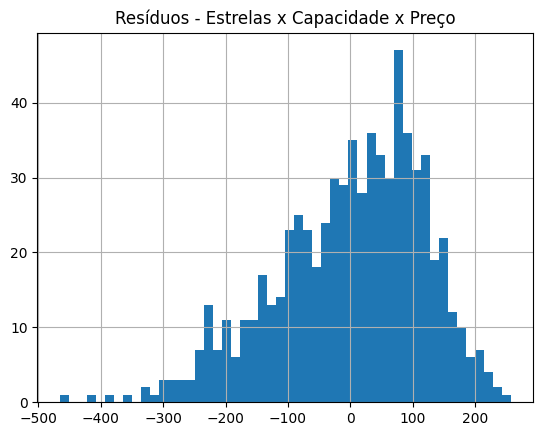

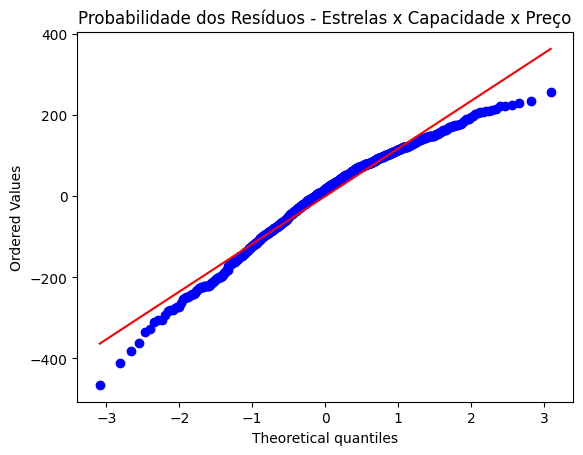

In [47]:
model_es_cp.resid.hist(bins=50)
plt.title("Resíduos - Estrelas x Capacidade x Preço")
plt.show()

(_, (_,_,_)) = probplot(model_es_cp.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Estrelas x Capacidade x Preço")
plt.show()

Para este modelo os resíduos ainda apresentam assimetria a esquerda, a mais forte vista até o momento, e os dados não exatamente se agrupam em torno de zero, indicando uma tendência a um erro maior na predição do modelo quando em valores muito extremos.

Porém, note que a explicabilidade dos dados aqui foi de 0.471, maior que os modelos simples anteriores para Estrelas e Capacidade.

### Modelo Proximidade x Estrelas

In [51]:
print(model_pt_es.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     556.6
Date:                Thu, 16 Jan 2025   Prob (F-statistic):          1.15e-144
Time:                        20:09:56   Log-Likelihood:                -4182.1
No. Observations:                 693   AIC:                             8370.
Df Residuals:                     690   BIC:                             8384.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                397.5409     10

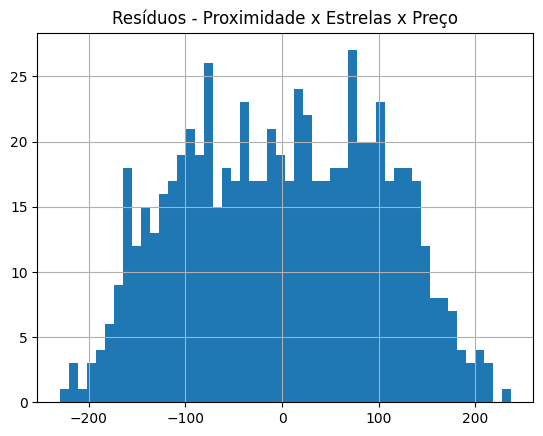

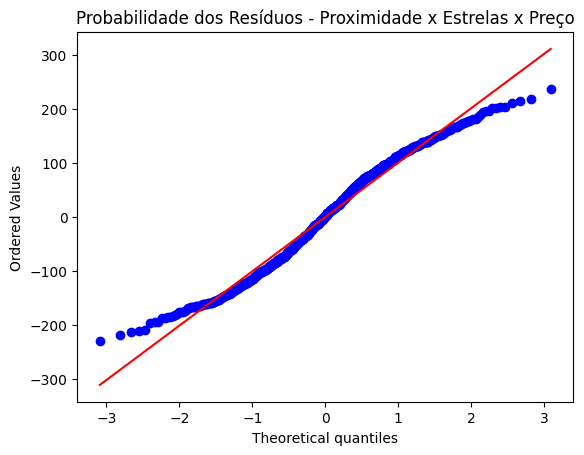

In [52]:
model_pt_es.resid.hist(bins=50)
plt.title("Resíduos - Proximidade x Estrelas x Preço")
plt.show()

(_, (_,_,_)) = probplot(model_pt_es.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Proximidade x Estrelas x Preço")
plt.show()

Aqui vemos um comportamento muito mais próximo de uma normal do que no modelo Estrelas x Capacidade.
Temos uma explicabilidade de 0.617, bem superior aos outros modelos até agora vistos.

### Modelo Proximidade x Capacidade

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     868.9
Date:                Thu, 16 Jan 2025   Prob (F-statistic):          3.15e-189
Time:                        20:16:42   Log-Likelihood:                -4079.1
No. Observations:                 693   AIC:                             8164.
Df Residuals:                     690   BIC:                             8178.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                353.6778      9

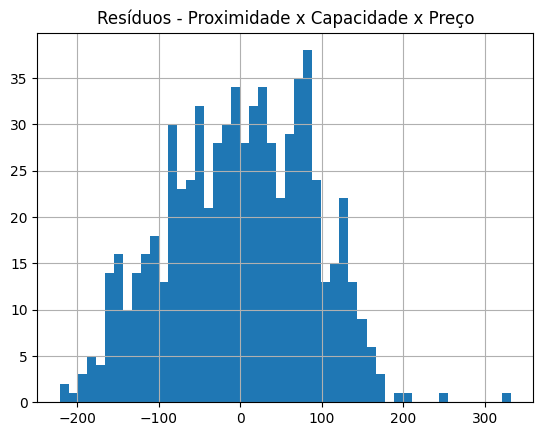

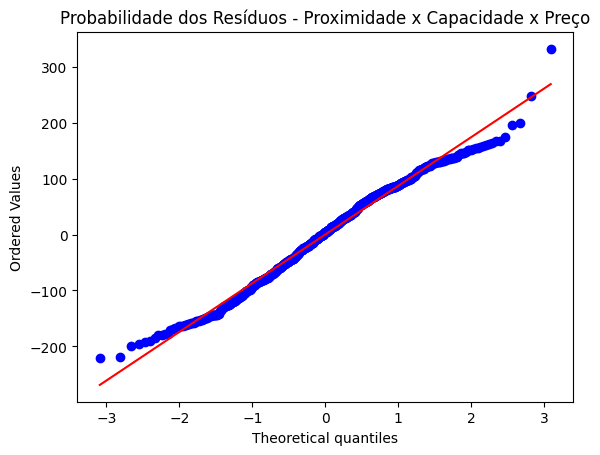

In [53]:
print(model_pt_cp.summary())

model_pt_cp.resid.hist(bins=50)
plt.title("Resíduos - Proximidade x Capacidade x Preço")
plt.show()

(_, (_,_,_)) = probplot(model_pt_cp.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Proximidade x Capacidade x Preço")
plt.show()

Temos aqui resíduos que se comportam bem como uma normal, memos tendo alguns valores extremos.

A explicabilidade aqui superou ainda a do modelo Proximidade x Estrelas, atingindo 0.716.

### Modelo Proximidade x Capacidade x Estrelas

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     2113.
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:20:24   Log-Likelihood:                -3710.3
No. Observations:                 693   AIC:                             7429.
Df Residuals:                     689   BIC:                             7447.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                195.4812      6

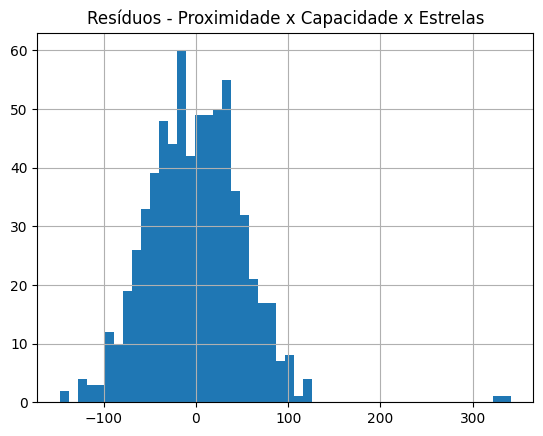

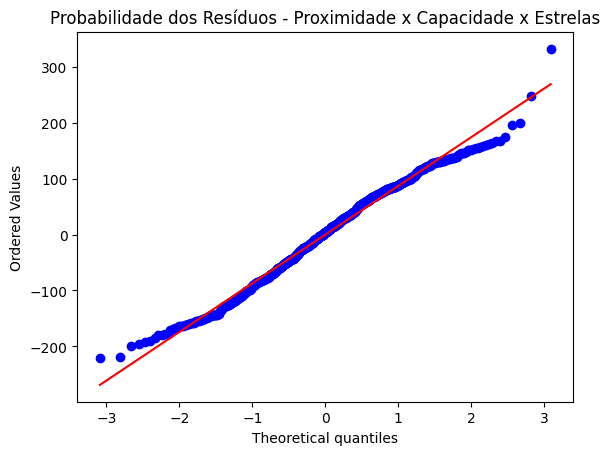

In [54]:
print(model_pt_cp_es.summary())

model_pt_cp_es.resid.hist(bins=50)
plt.title("Resíduos - Proximidade x Capacidade x Estrelas")
plt.show()

(_, (_,_,_)) = probplot(model_pt_cp.resid, plot = plt)
plt.title("Probabilidade dos Resíduos - Proximidade x Capacidade x Estrelas")
plt.show()

Por fim o modelo completo, com todas as variáveis independentes possíveis. Novamente resíduos se comportando como uma normal e bem agrupados em torno de 0. Com uma explicabilidade de 0.902 e nada que indique algum viés ou problema na regressão, este acaba sendo o melhor modelo gerado.

### Resultados Finais

Após analisar todos os modelos gerados temos os seguintes resultados:

||Proximidade|Capacidade|Estrelas|Capacidade x Estrelas|Proximidade x Estrelas|Proximidade x Capacidade|Proximidade x Capacidade x Estrelas|
|-|-|-|-|-|-|-|-|
|**R²**|0.446|0.261|0.194|0.471|0.617|0.716|0.902|
|**R² Adj.**|0.445|0.260|0.193|0.469|0.616|0.715|0.902|
|**R² Prev.**|0.435|0.323|0.100|-|-|-|-|

Considerando que não houve indicações de viéses nem de qualquer outro problema nos valores do modelo saturado (Proximidade, Capacidade e Estrelas), este acaba por ser o melhor modelo e o que deve ser utilizado para predições e tomadas de decisão sobre as hospedagens.

Verifiquemos novamente os parâmetros do modelo escolhido:

In [55]:
model_pt_cp_es.params

const                 195.481203
Estrelas               49.562747
ProximidadeTurismo    -18.622218
Capacidade             78.343474
dtype: float64

Os valores acima nos dizem que, quando mantidas todas as variáveis constantes e:
- Alteramos em uma unidade o número de estrelas, de forma proporcional alteramos o valor em R$49.56.
- Alteramos em uma unidade a capacidade, de forma proporcional alteramos o valor em R$78.34.
- Alteramos em uma unidade a distância de um ponto turístico, de forma inversamente proporcional alteramos o valor em R$18.62.

O valor da constante representa o intercepto. Caso todas as variáveis fossem zero, o valor da hospedagem estaria em torno de R$195.48.